In [140]:
import numpy as np
import random
import matplotlib.pyplot as plt

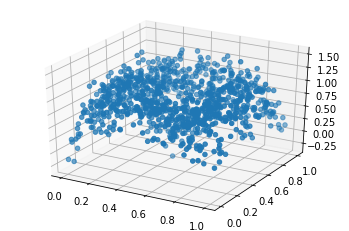

In [141]:
def latent_func(x, y):
    return np.sin(np.pi * np.sqrt(((x - 0.5) ** 2 + (y - 0.5) ** 2) / 0.5))

def gen_data(total_example_count, noise_sigma):
    # generate random points in 0 <= x, y <= 1
    X = np.random.random_sample((total_example_count, 2))
    y = np.asarray(list(map(lambda xy: [latent_func(xy[0], xy[1]) + random.gauss(0, noise_sigma)], X)))
    return X, y

X, y = gen_data(1000, 0.2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X.T[0], X.T[1], y.T);

In [142]:
class MyNeuralNets:
    """ Simple Feed-Forward NN.
    """
    def __init__(self, layers):
        """ Construct a ff-NN with given layer configs.
        
        Args:
            layers: a list of integers, like [2, 3, 1]
        """
        if len(layers) < 2 or min(layers) < 1:
            raise Exception('invalid layers')
        self._in_dim = layers[0]
        self._out_dim = layers[-1]
        self._layers = layers
        
        self._weight = []
        for i in range(len(layers) - 1):
            self._weight.append(np.random.rand(layers[i]+1, layers[i+1]) - 0.5)
        
    def train(self, X, y, epoch):
        rmse = self.evaluate(X, y)
        rmse_history = [rmse]
        for ep in range(epoch):
            step = 0.1
            batch_size = 10
            for i in range(int(len(X)/batch_size)):
                idx = i * batch_size
                self._train_one_batch(X[idx:idx+batch_size], y[idx:idx+batch_size], step)
            rmse = self.evaluate(X, y)
            #print("Epoch", ep, "RMSE", rmse)
            rmse_history.append(rmse)
        return rmse_history
    
    def _train_one_batch(self, x, y, step):
        batch_size = int(x.size / self._in_dim)
        x.shape = (batch_size, self._in_dim)
        y.shape = (batch_size, self._out_dim)
        ## forward-prop
        states = []
        for i in range(len(self._weight)):
            if len(states) == 0:
                prev_out = np.array(x)
            else:
                prev_out = self._actv_func(states[-1][1])
            prev_out = np.append(prev_out, np.ones((batch_size, 1)), axis=1) # add offset
            curr_out = np.matmul(prev_out, self._weight[i]) # prev/curr_out.shape = (batch_size, node_nums)
            states.append([prev_out, curr_out])
        ## back-prop
        for i in reversed(range(len(self._weight))):
            if i == len(self._weight) - 1:
                curr_grads = -1. * (states[i][1] - y) * step # grads.shape = (batch_size, out_dim)
            else:
                curr_grads *= self._d_actv_func(states[i][1])
            next_grads = np.matmul(curr_grads, self._weight[i].T)
            self._weight[i] += np.matmul(states[i][0].T, curr_grads) / batch_size
            curr_grads = np.delete(next_grads, len(next_grads[0]) - 1, axis=1) # remove offset
 
    def predict(self, x):
        x.shape = (1, self._in_dim)
        for layer in self._weight[:-1]:
            x = np.append(x, [[1]], axis=1)
            x = self._actv_func(np.matmul(x, layer))
        x = np.append(x, [[1]], axis=1)
        x = np.matmul(x, self._weight[-1])
        return x
    
    def evaluate(self, X, y):
        _y = np.apply_along_axis(self.predict, axis=1, arr=X)
        _y.shape = y.shape
        rmse = (np.square(_y - y)).mean(axis=0) ** 0.5
        return rmse
    
    def _actv_func(self, value):
        # ReLU
        relu = np.vectorize(lambda x : max(0., x))
        return relu(value)
    
    def _d_actv_func(self, value):
        d_relu = np.vectorize(lambda x : 1 if x > 0 else 0)
        return d_relu(value)
    
    def debug_dump(self):
        print(self._weight)

ffnn = MyNeuralNets([2, 8, 16, 4, 1])

#ffnn.debug_dump()
#ffnn._train_one_batch(np.array([0, 1]), np.array([0]), 0.01)

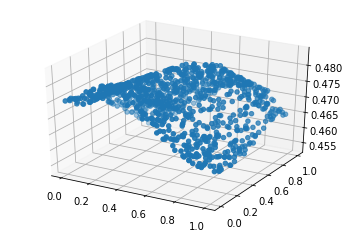

In [143]:
_y = np.apply_along_axis(ffnn.predict, axis=1, arr=X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X.T[0], X.T[1], _y.T);

Final RMSE: [0.21185371]


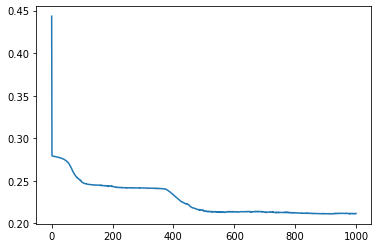

In [144]:
rmse_history = ffnn.train(X, y, epoch=1000)

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(rmse_history)), rmse_history);

print("Final RMSE:", ffnn.evaluate(X, y))

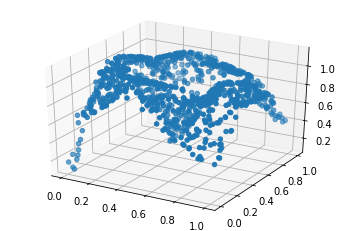

In [145]:
_y = np.apply_along_axis(ffnn.predict, axis=1, arr=X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X.T[0], X.T[1], _y.T);

In [146]:
ffnn.debug_dump()

[array([[-0.44128498, -0.34333656, -0.27688909,  1.68885646,  2.47579142,
         0.54672521, -0.27860938,  0.18030193],
       [-0.22723756,  1.23965338, -1.87058411, -2.17250264, -0.17072452,
        -0.66477157, -0.48677631, -0.06418106],
       [-0.466706  ,  0.24178073,  1.58392379,  0.2682211 , -0.09904456,
        -0.00391483, -0.23913863, -0.22000567]]), array([[-0.02042123,  0.46145483,  0.19121156,  0.42017191, -0.19781344,
        -0.17056342, -0.02976694, -0.2253815 ,  0.20796924, -0.27620972,
        -0.47984383,  0.07704992,  0.29585467,  0.03099727,  0.23097114,
        -0.00440451],
       [-0.15207815, -0.93720943, -0.20992368,  0.12505716,  0.28791469,
         0.28264593, -0.28411911,  1.08491965,  0.55658266, -0.19213531,
         0.58732148, -0.6014675 ,  0.57426199,  0.16671321,  0.56498071,
        -0.1925529 ],
       [-0.16372336,  0.31025646, -0.7152115 , -0.06327278,  0.81521762,
         1.23225158, -0.31294219, -0.03024585,  0.55140636, -0.32982889,
      